# Data Source

This data set is from Kaggle: https://www.kaggle.com/datasets/yasserh/walmart-dataset/data
It is a very clean dataset designed to perform ML on predicting weekly sales of Walmart stores using different variables. 

# Importing Libraries

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error


# Importing data and Data Exploration

In [2]:
data = pd.read_csv("Walmart.csv")
data.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [4]:
data.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [5]:
data.duplicated().sum()

0

In [6]:
data.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


- There are no duplicate or empty rows
- Weekly sales has some outliers but it seems like a normal situation. Might have to dig further.
- There are some negative temperature

# Feature Engineering

Segregate date into Quarter, year, week and month

In [7]:
data["Date"] = pd.to_datetime(data["Date"],dayfirst= True)
data["Quarter"]=data["Date"].dt.quarter
data['Week'] = data['Date'].dt.isocalendar().week
data['Month'] = data['Date'].dt.month
data["Year"] = data["Date"].dt.year
data.drop("Date", axis = 1, inplace = True)
data.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Quarter,Week,Month,Year
0,1,1643690.90,0,42.31,2.572,211.096358,8.106,1,5,2,2010
1,1,1641957.44,1,38.51,2.548,211.242170,8.106,1,6,2,2010
2,1,1611968.17,0,39.93,2.514,211.289143,8.106,1,7,2,2010
3,1,1409727.59,0,46.63,2.561,211.319643,8.106,1,8,2,2010
4,1,1554806.68,0,46.50,2.625,211.350143,8.106,1,9,3,2010


In [8]:
for i in data.columns:
    print(f'{i}: {data[i].nunique()}')

Store: 45
Weekly_Sales: 6435
Holiday_Flag: 2
Temperature: 3528
Fuel_Price: 892
CPI: 2145
Unemployment: 349
Quarter: 4
Week: 52
Month: 12
Year: 3


# EDA

## Univariate Analysis

### Quantitative values

- Weekly_sales
- Temperature
- Fuel_Price
- CPI
- Unemployment

In [9]:
columns = data[['Weekly_Sales', 'Temperature', 'Fuel_Price',"CPI", 'Unemployment']].describe()

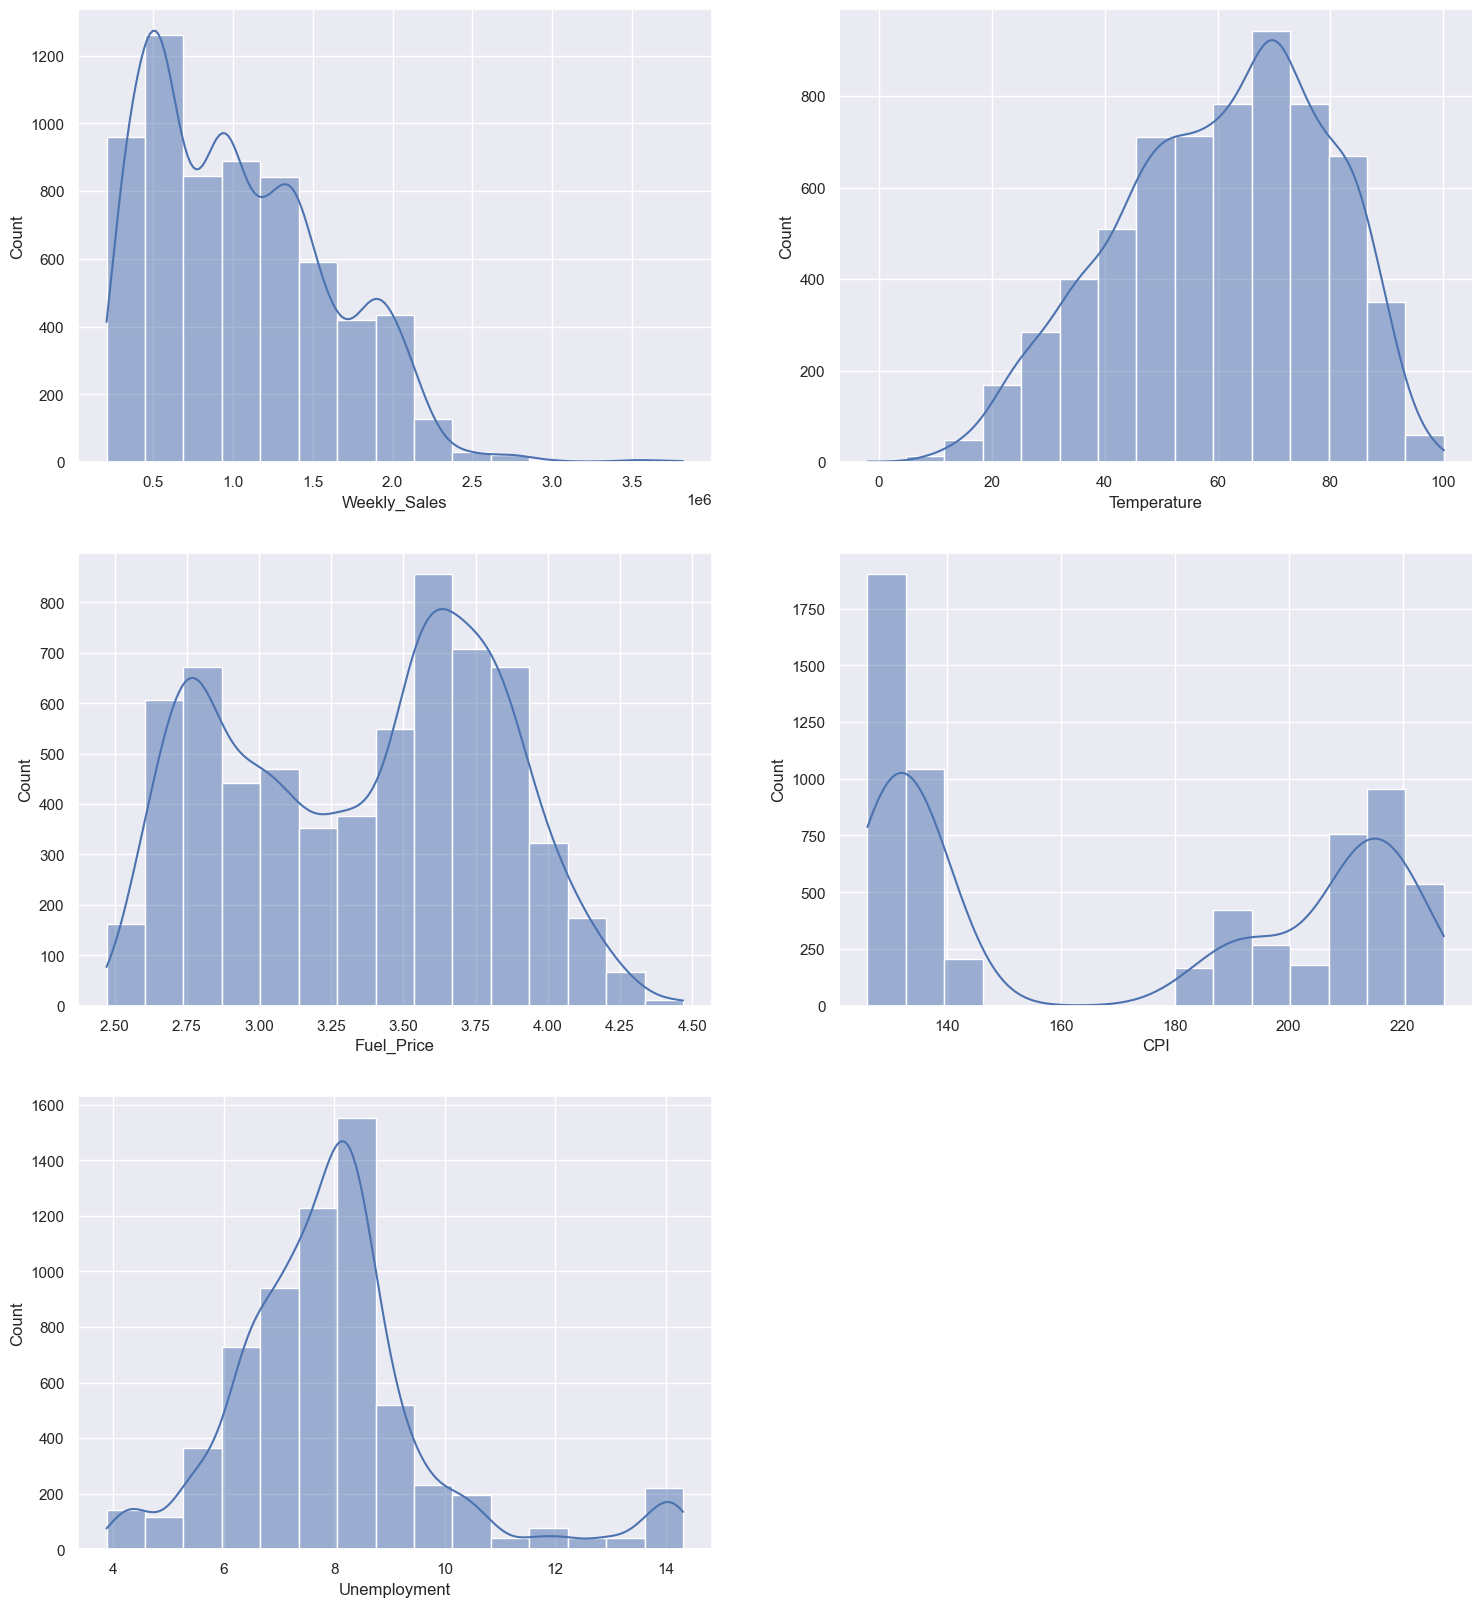

In [10]:
plt.figure(figsize=(18, 20))
for i,col in enumerate(columns):
    plt.subplot(3, 2, i+1)
    sns.histplot(data = data, x = col, kde = True, bins = 15, color = 'b')
plt.show()

- Weekly sales is right skewed
- Temperature and unemployment are normally distributed
- Fuel price and CPI are bimodal

#### Weekly Sales Analysis

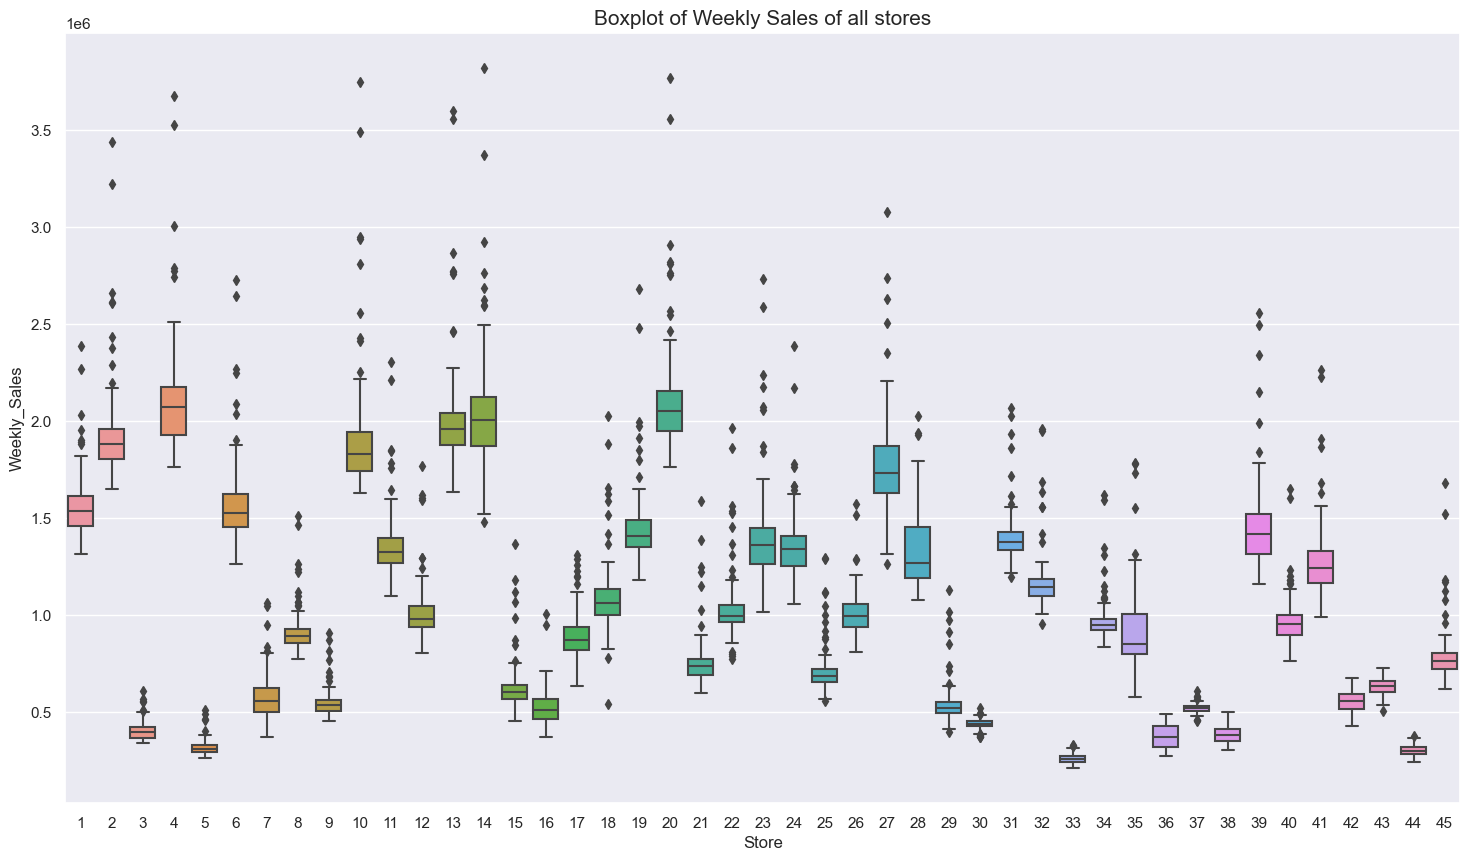

In [11]:
plt.figure(figsize = (18,10))
sns.boxplot(y=data["Weekly_Sales"],x=data["Store"])
plt.title("Boxplot of Weekly Sales of all stores",size = 15)
plt.show()

The $3.8m outlier does not seem to be an impossible figure

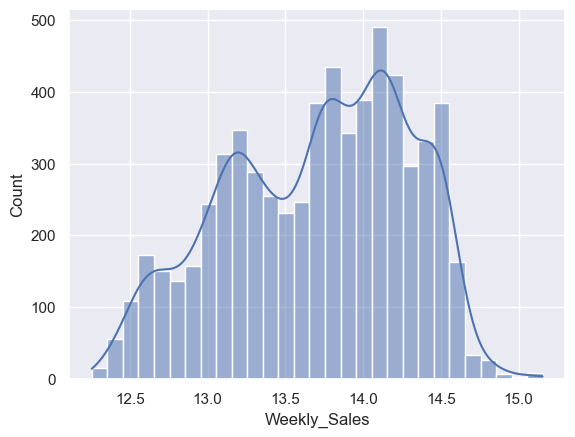

In [12]:
sns.histplot(np.log(data["Weekly_Sales"]),kde = True)
plt.show()

Might be a better idea to log transform the weekly sales to make it more normal

#### Temperature Analysis

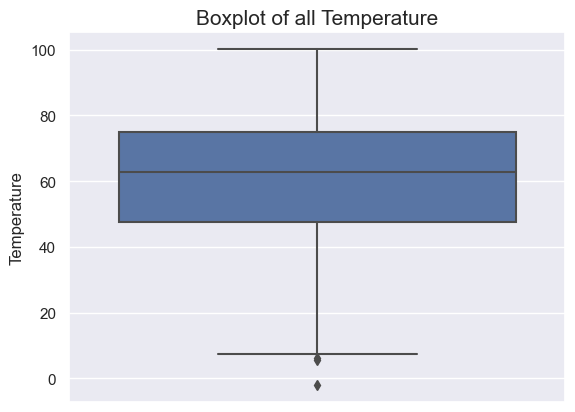

In [13]:
sns.boxplot(y=data["Temperature"])
plt.title("Boxplot of all Temperature",size = 15)
plt.show()

In [14]:
q1 = data["Temperature"].quantile(0.25)
q3 = data["Temperature"].quantile(0.75)
iqr = q3-q1
data[data["Temperature"]<q1-1.5*iqr]

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Quarter,Week,Month,Year
910,7,558027.77,0,-2.06,3.011,191.762589,8.818,1,5,2,2011
2336,17,1083071.14,0,6.23,2.891,127.191774,6.866,1,1,1,2011
3626,26,817485.14,0,5.54,3.243,133.105968,7.907,1,4,1,2011


Extreme temperature value maybe considered for removal or standardised due to it even being a negative number, but depending on the region the stores are located, the figure itself doesn't not seem to be an error of some kind.

#### Unemployment

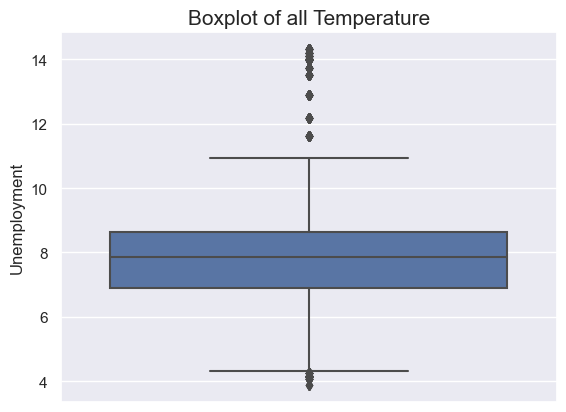

In [15]:
sns.boxplot(y=data["Unemployment"])
plt.title("Boxplot of all Temperature",size = 15)
plt.show()

Unemployment has a very skewed data. Logging it seem to give it a more normal look.

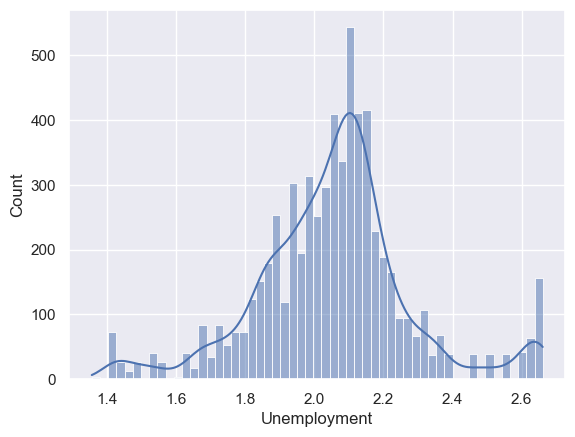

In [16]:
sns.histplot(np.log(data["Unemployment"]),kde = True)
plt.show()

### Bivariate Analysis

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_32944\268900218.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


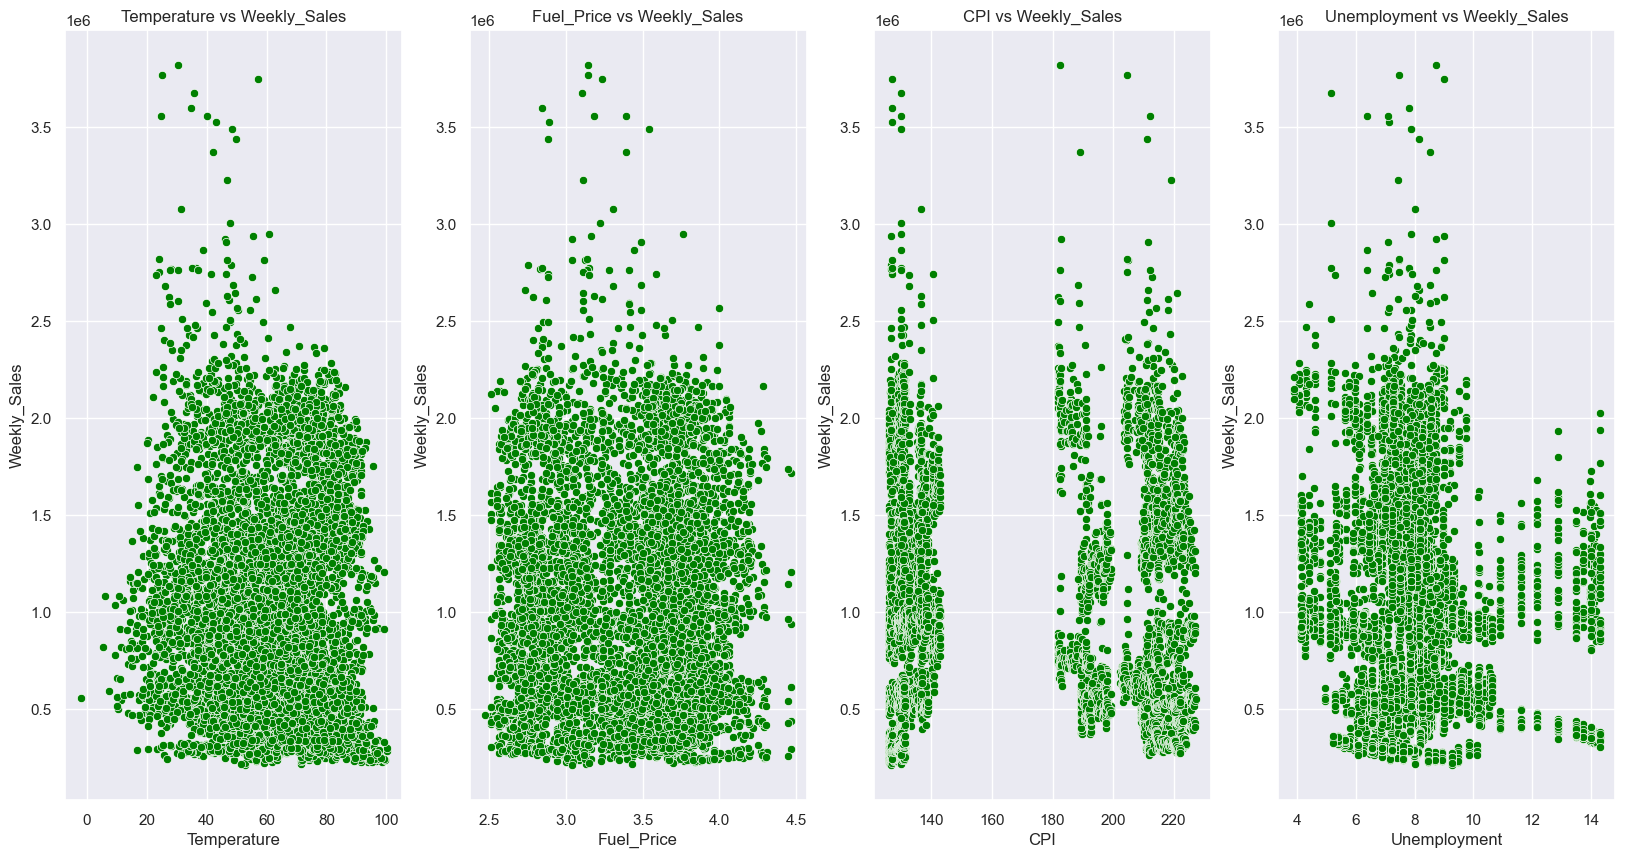

In [17]:
fig , ax = plt.subplots(1,4,figsize=(20,10))
cols = ['Temperature','Fuel_Price','CPI','Unemployment']
for i,col in enumerate(cols):
    sns.scatterplot(data,
                 y='Weekly_Sales',x=col,
                 ax=ax[i],
                 color = 'green'
                )
    ax[i].set_title(f'{col} vs Weekly_Sales')
fig.show()    

- None of the quantitative variables seem to show a linear pattern with weekly sales

### Qualitative/Time Series Variables

#### Stores

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_32944\1461021904.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(data = data,


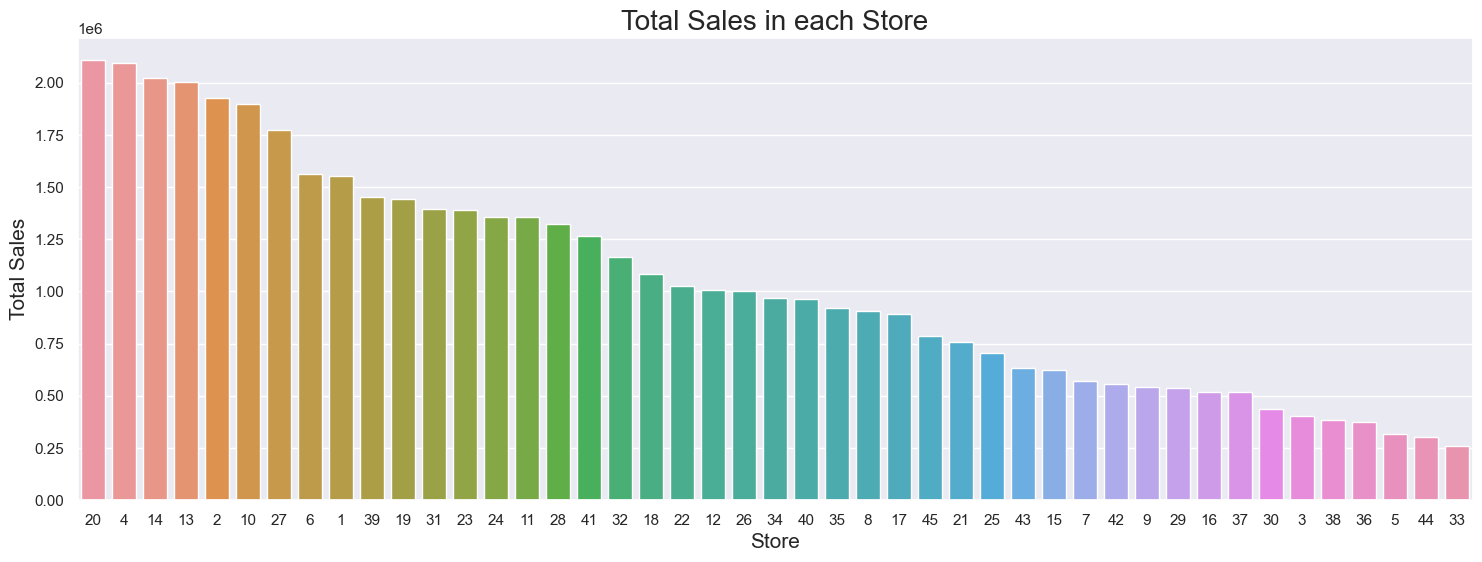

In [18]:
grouped_store = data.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending = False)

plt.figure(figsize = (18, 6))
sns.barplot(data = data,
            x = 'Store',
            y = 'Weekly_Sales',
            order = grouped_store.index,
            ci = False)

# Add labels and title
plt.title('Total Sales in each Store', size = 20)
plt.xlabel('Store', size = 15)
plt.ylabel('Total Sales', size = 15)
plt.show()

Stores 20,4,14,13 generated the most sales while store 36,5,44,33 generated the least amount of sales.

#### Holidays

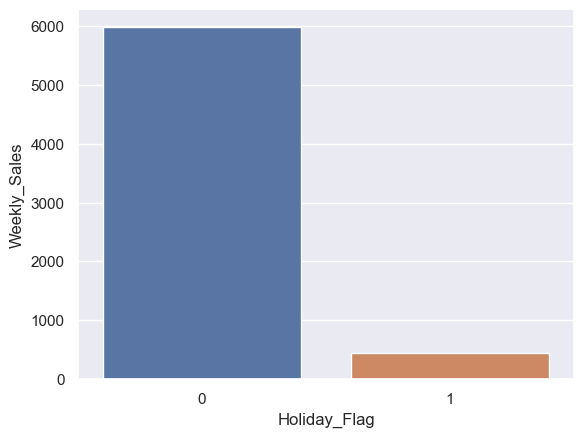

In [19]:
holiday = data.groupby(["Holiday_Flag"])["Weekly_Sales"].count()
sns.barplot(x=holiday.index,y=holiday)
plt.show()

There are more non-holiday weeks.

#### Yearly

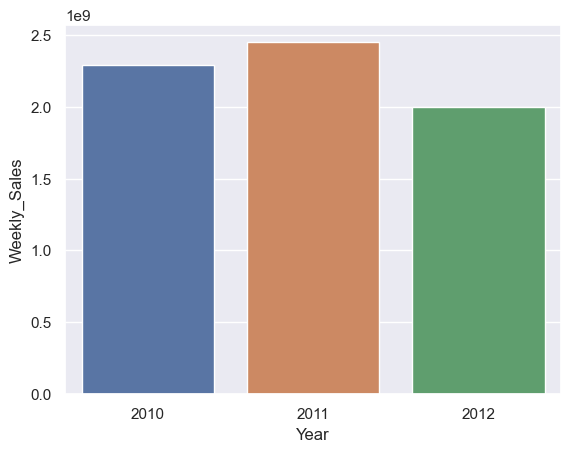

In [20]:
yearly = data.groupby(["Year"])["Weekly_Sales"].sum()
sns.barplot(x=yearly.index,y=yearly)
plt.show()

#### Quarterly

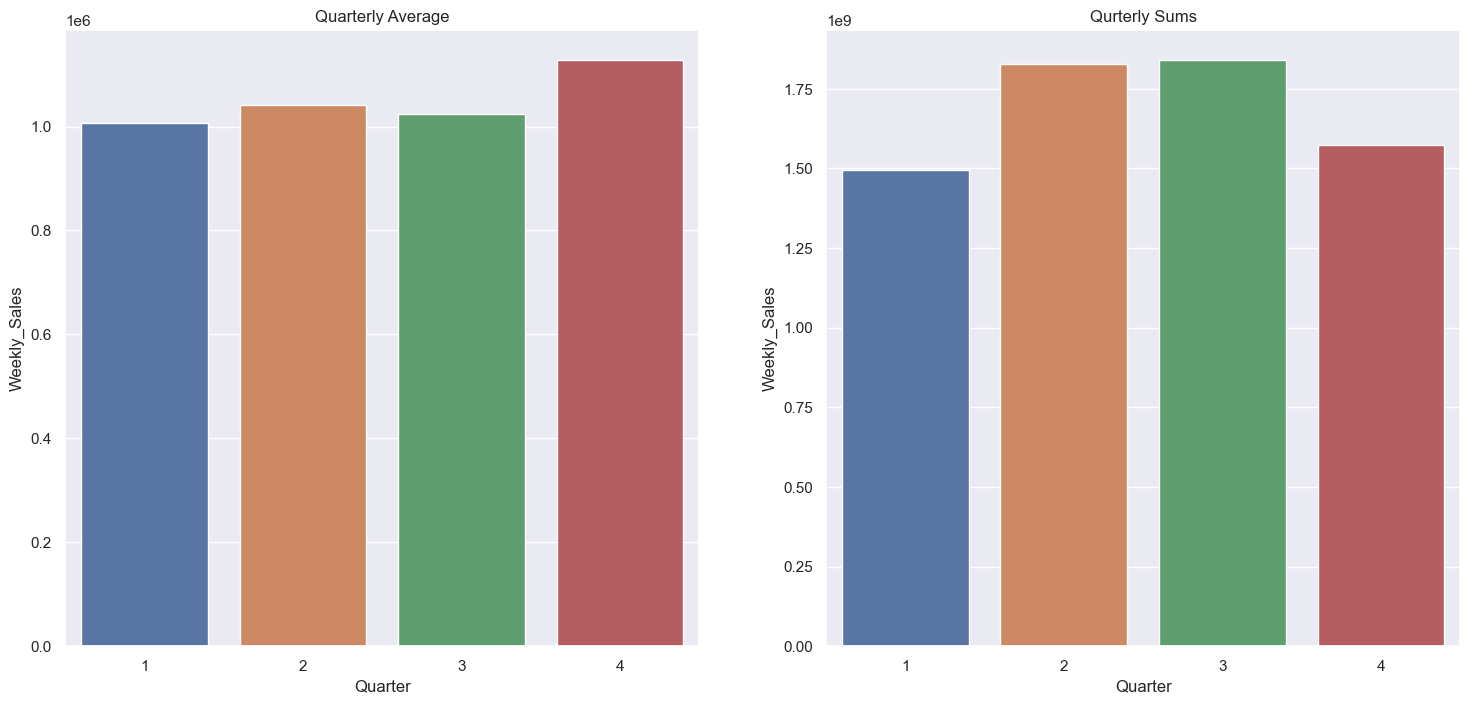

In [21]:
plt.figure(figsize = (18, 8))
yearly_mean = data.groupby(["Quarter"])["Weekly_Sales"].mean()
yearly_sum = data.groupby(["Quarter"])["Weekly_Sales"].sum()
plt.subplot(1, 2, 1)
sns.barplot(x=yearly_mean.index,y=yearly_mean)
plt.title("Quarterly Average")
plt.subplot(1, 2, 2)
sns.barplot(x=yearly_sum.index,y=yearly_sum)
plt.title("Qurterly Sums")
plt.show()

In [22]:
data.groupby(["Quarter"])["Weekly_Sales"].count()

Quarter
1    1485
2    1755
3    1800
4    1395
Name: Weekly_Sales, dtype: int64

There are more data on second and third qurters thus more sales in raw quantity. However, the most sales are happening on average on the fourth quarter.

#### Weekly

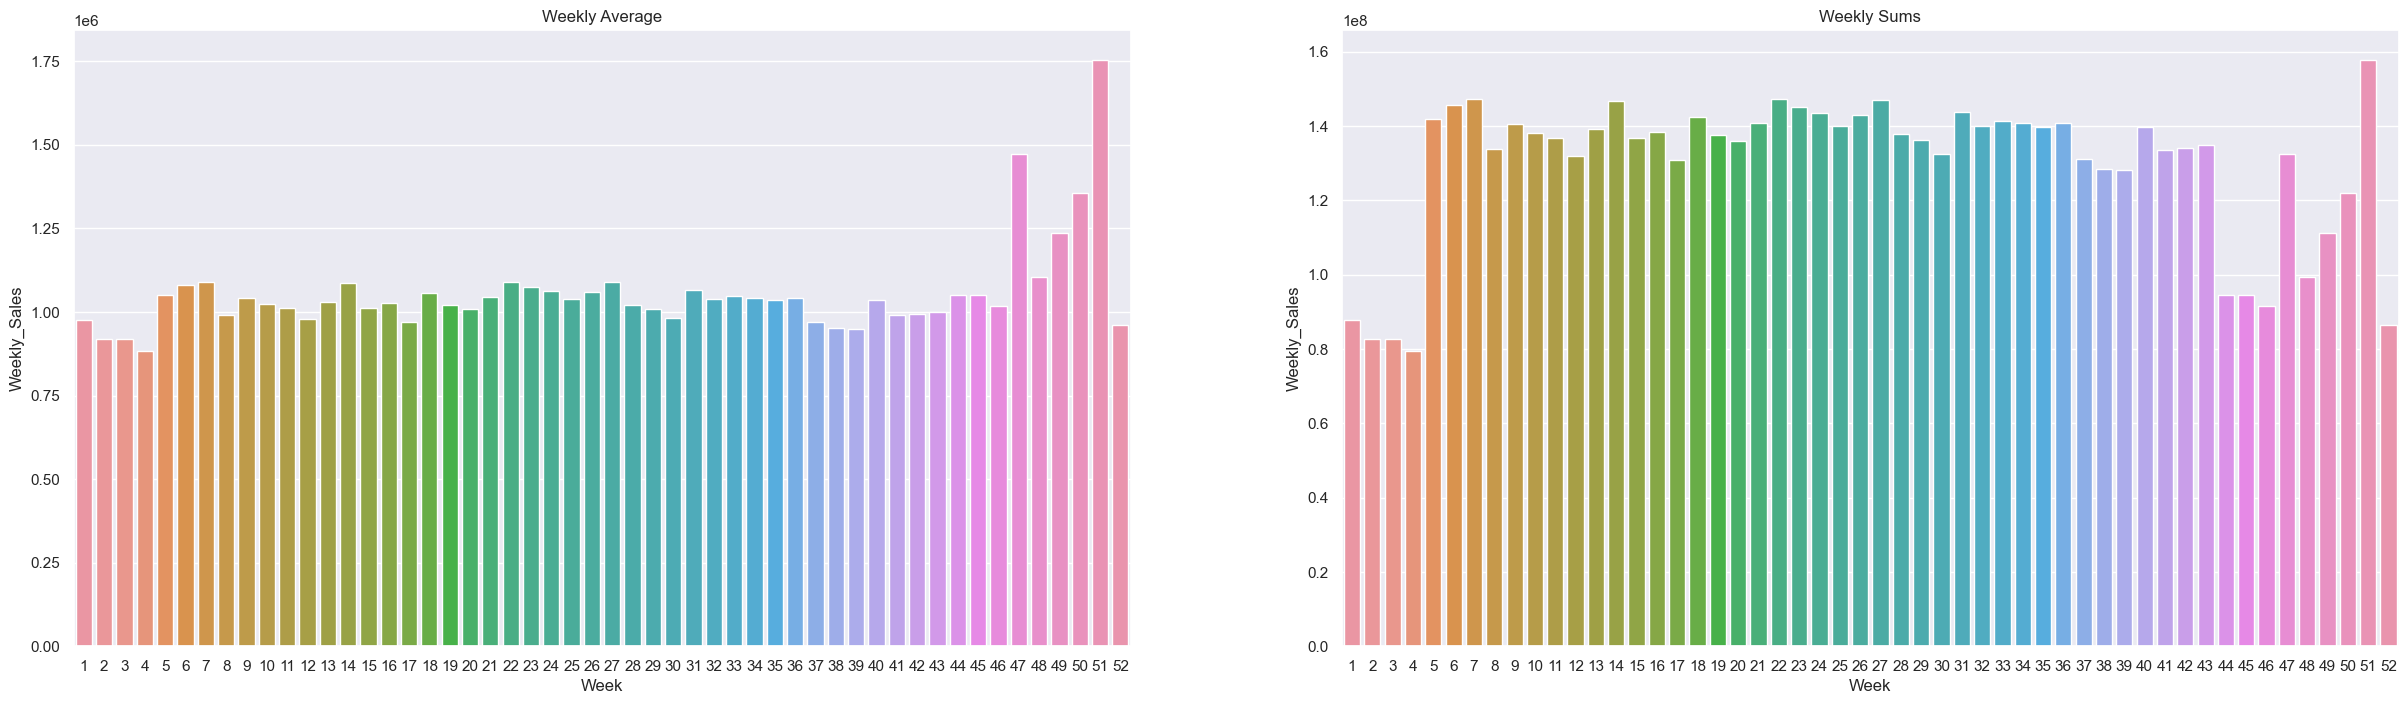

In [23]:
plt.figure(figsize = (30, 8))
yearly_mean = data.groupby(["Week"])["Weekly_Sales"].mean()
yearly_sum = data.groupby(["Week"])["Weekly_Sales"].sum()
plt.subplot(1, 2, 1)
sns.barplot(x=yearly_mean.index,y=yearly_mean)
plt.title("Weekly Average")
plt.subplot(1, 2, 2)
sns.barplot(x=yearly_sum.index,y=yearly_sum)
plt.title("Weekly Sums")
plt.show()

On average, most weeks are similar except for weeks 47-52. 

# Correlation

<Axes: >

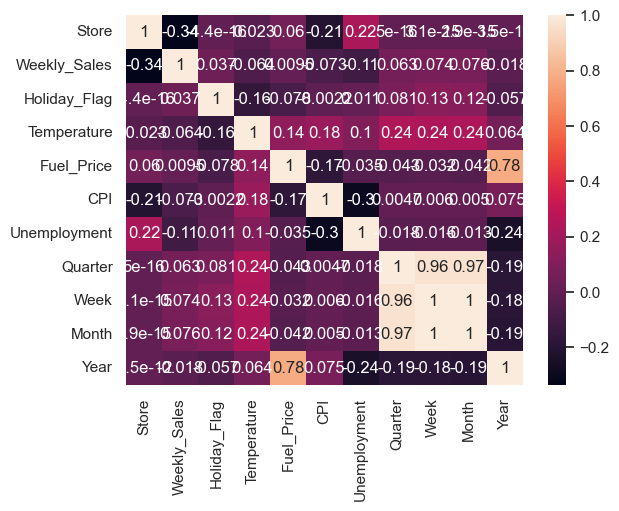

In [24]:
sns.heatmap(data.corr(),annot=True)

There doesn't seem to be any correlation between the variables except the year and fuel price, and as expected high correlation between the time related variables.

## Processing/Removing variables

Remove extreme values in temperature

In [25]:
data = data[data["Temperature"]>q1-1.5*iqr]

Remove year,month, week. Just keep quarter

In [26]:
data = data.drop(["Year","Month","Week"],axis = 1)

Check data types and convert categorical variables

In [27]:
data.dtypes

Store             int64
Weekly_Sales    float64
Holiday_Flag      int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
Quarter           int64
dtype: object

In [28]:
data["Store"] = data["Store"].astype("object")
data["Holiday_Flag"] = data["Holiday_Flag"].astype("object")
data["Quarter"] = data["Quarter"].map({1:"Q1",2:"Q2",3:"Q3",4:"Q4"})

Encode Categorical Variables and standardise numerical ones

In [29]:
#One Hot encoder for categorical values, and standard scalar for the numerical values.
encoder = OneHotEncoder()
sc = StandardScaler()

X_encoded = encoder.fit_transform(data[["Store","Quarter"]]).toarray()
X_rest = data.drop(["Store","Quarter"],axis = 1)
numerical_col = X_rest.columns

#We need to separately log transform and keep it separate before we standardise the numerical values. 
X_rest_log = X_rest.copy()
X_rest_log ["Weekly_Sales"] = np.log(X_rest_log["Weekly_Sales"] )
X_rest_log ["Unemployment"] = np.log(X_rest_log["Unemployment"] )
X_rest_log  = sc.fit_transform(X_rest_log )
num_scaled_log = pd.DataFrame(X_rest_log,columns = numerical_col)

#standardise the non-log transformed dataframe.
X_rest = sc.fit_transform(X_rest)
num_scaled = pd.DataFrame(X_rest,columns = numerical_col)

#combine the categorical and non-categorical
feature_labels = np.hstack(encoder.categories_)
cat_encoded = pd.DataFrame(X_encoded, columns = feature_labels)
data = pd.concat([num_scaled,cat_encoded],axis = 1)
data.drop([1,"Q1"],axis =1 , inplace= True)

#do the same for log transformed dataframe
feature_labels = np.hstack(encoder.categories_)
cat_encoded = pd.DataFrame(X_encoded, columns = feature_labels)
data_transformed = pd.concat([num_scaled_log,cat_encoded],axis = 1)
data_transformed.drop([1,"Q1"],axis =1 , inplace= True)

In [30]:
data

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,2,3,4,5,...,39,40,41,42,43,44,45,Q2,Q3,Q4
0,1.057061,-0.274273,-0.998626,-1.713939,1.003888,0.056919,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.053990,3.646002,-1.205082,-1.766223,1.007593,0.056919,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000856,-0.274273,-1.127932,-1.840292,1.008786,0.056919,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.642537,-0.274273,-0.763918,-1.737902,1.009561,0.056919,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.899580,-0.274273,-0.770981,-1.598478,1.010336,0.056919,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6427,-0.591582,-0.274273,0.227614,1.390425,0.519002,0.365006,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
6428,-0.555649,-0.274273,0.228157,1.364283,0.522987,0.355945,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
6429,-0.553860,-0.274273,-0.337967,1.396960,0.526973,0.355945,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
6430,-0.582809,-0.274273,-0.229306,1.329427,0.527064,0.355945,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [31]:
data_transformed

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,2,3,4,5,...,39,40,41,42,43,44,45,Q2,Q3,Q4
0,1.037616,-0.274273,-0.998626,-1.713939,1.003888,0.172865,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.035823,3.646002,-1.205082,-1.766223,1.007593,0.172865,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.004493,-0.274273,-1.127932,-1.840292,1.008786,0.172865,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.776639,-0.274273,-0.763918,-1.737902,1.009561,0.172865,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.943127,-0.274273,-0.770981,-1.598478,1.010336,0.172865,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6427,-0.381544,-0.274273,0.227614,1.390425,0.519002,0.479155,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
6428,-0.333884,-0.274273,0.228157,1.364283,0.522987,0.470441,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
6429,-0.331547,-0.274273,-0.337967,1.396960,0.526973,0.470441,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
6430,-0.369784,-0.274273,-0.229306,1.329427,0.527064,0.470441,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


Create copy of the data to make dataframe with log transformed variables

In [32]:
# data_transformed = data.copy()
# data_transformed["Weekly_Sales"] = np.log(data_transformed["Weekly_Sales"] )
# data_transformed["Unemployment"] = np.log(data_transformed["Unemployment"] )

In [33]:
# data_transformed

# Data Modeling

In [34]:
X = data.drop(["Weekly_Sales"],axis = 1)
X.columns = X.columns.astype(str)
y = data["Weekly_Sales"]
X_transformed = data_transformed.drop(["Weekly_Sales"],axis = 1)
X_transformed.columns = X_transformed.columns.astype(str)
y_transformed = data_transformed["Weekly_Sales"]

In [35]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=7)
X_transformed_train,X_transformed_test,y_transformed_train,y_transformed_test = train_test_split(X_transformed, y_transformed, test_size=0.2, random_state=7)

## Linear Regression

### Not Transformed

In [36]:
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [37]:
y_pred = model.predict(X_test)
print(f"Mean Absolute Error: {mean_absolute_error(y_test,y_pred)}")
print(f"Mean Squared Error: {mean_squared_error(y_test,y_pred)}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_test,y_pred))}")
print(f"R2 Score: {r2_score(y_test,y_pred)}")

Mean Absolute Error: 0.16548702637333146
Mean Squared Error: 0.07467929831451404
Root Mean Squared Error: 0.2732751329969744
R2 Score: 0.9221339967824214


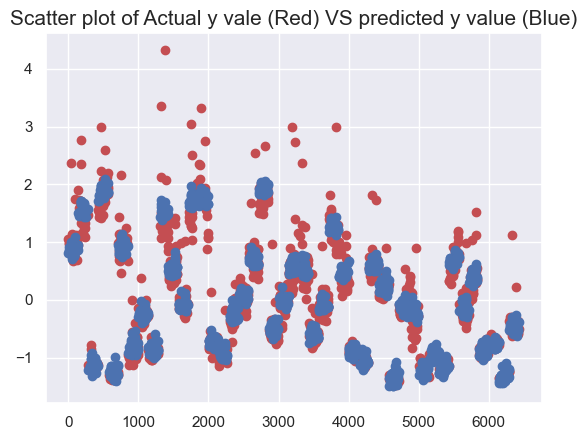

In [98]:
plt.scatter(y_test.index,(y_test),color = "r")
plt.scatter(y_test.index,(y_pred),c = "b")
plt.title("Scatter plot of Actual y vale (Red) VS predicted y value (Blue)",size = 15)
plt.show()

## Log Transformed

In [38]:
model = LinearRegression()
model.fit(X_transformed_train,y_transformed_train)

LinearRegression()

In [39]:
y_transformed_pred = model.predict(X_transformed_test)
print(f"Mean Absolute Error: {mean_absolute_error(y_transformed_test,y_transformed_pred)}")
print(f"Mean Squared Error: {mean_squared_error(y_transformed_test,y_transformed_pred)}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_transformed_test,y_transformed_pred))}")
print(f"R2 Score: {r2_score(y_transformed_test,y_transformed_pred)}")

Mean Absolute Error: 0.13785043729174865
Mean Squared Error: 0.04012887189723482
Root Mean Squared Error: 0.2003219206608074
R2 Score: 0.9593435471824077


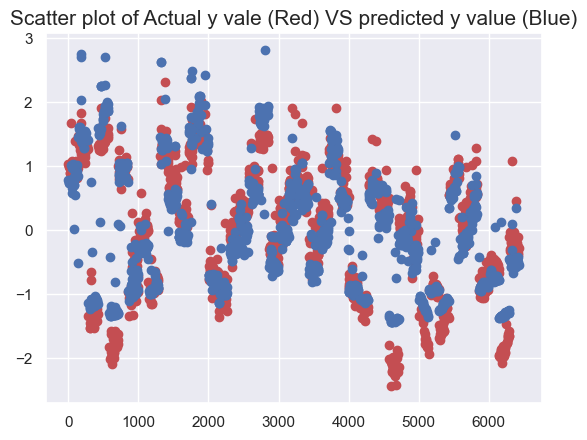

In [99]:
plt.scatter(y_transformed_test.index,y_transformed_test,color = "r")
plt.scatter(y_transformed_test.index,y_transformed_pred,c = "b")
plt.title("Scatter plot of Actual y vale (Red) VS predicted y value (Blue)",size = 15)
plt.show()

The log transformation has improved the scores on all metrics

## K Neighbour

In [94]:
model = KNeighborsRegressor()
model.fit(X_train,y_train)

KNeighborsRegressor()

In [95]:
y_transformed_pred = model.predict(X_transformed_test)
print(f"Mean Absolute Error: {mean_absolute_error(y_transformed_test,y_transformed_pred)}")
print(f"Mean Squared Error: {mean_squared_error(y_transformed_test,y_transformed_pred)}")
print(f"Root Mean Squared Error: {np.sqrt(mean_squared_error(y_transformed_test,y_transformed_pred))}")
print(f"R2 Score: {r2_score(y_transformed_test,y_transformed_pred)}")

Mean Absolute Error: 0.2794698084887275
Mean Squared Error: 0.14059556024338257
Root Mean Squared Error: 0.37496074493656345
R2 Score: 0.8575560066568446


So far, the log transformed linear regression model seems to be performing the best. 